In [1]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import genfromtxt
from keras import backend as K
K.set_image_data_format('channels_first')
from keras.models import Model,Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense


Using TensorFlow backend.


In [2]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    print("Inside triplet loss")
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    print(anchor)
    print(positive)
    print(negative)
    ### START CODE HERE ### (˜ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    ### END CODE HERE ###
    
    print("Entering the function")
    return loss


In [3]:
def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)
    
             
    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [4]:
_FLOATX = 'float32'
def variable(value, dtype=_FLOATX, name=None):
    v = tf.Variable(np.asarray(value, dtype=dtype), name=name)
    _get_session().run(v.initializer)
    return v

def shape(x):
    return x.get_shape()

def square(x):
    return tf.square(x)

def zeros(shape, dtype=_FLOATX, name=None):
    return variable(np.zeros(shape), dtype, name)

def concatenate(tensors, axis=-1):
    if axis < 0:
        axis = axis % len(tensors[0].get_shape())
    return tf.concat(axis, tensors)

def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

WEIGHTS_mod = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3'
]
conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3]
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS_mod
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = './weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS_mod:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict

def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    flat_input=embedding.flatten()
    return embedding


In [5]:

FRmodel = faceRecoModel(input_shape=(3, 350, 350))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

Inside triplet loss
Tensor("loss/lambda_1_loss/strided_slice:0", shape=(128,), dtype=float32)
Tensor("loss/lambda_1_loss/strided_slice_1:0", shape=(128,), dtype=float32)
Tensor("loss/lambda_1_loss/strided_slice_2:0", shape=(128,), dtype=float32)
Entering the function


In [6]:
 def show_images(image_path_original,image_path_check):
    
    imageA=mpimg.imread(image_path_original)
    imageB=mpimg.imread(image_path_check)
    fig = plt.figure("Comparison")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

In [7]:
def verify(image_path_original, image_path_check, model): 
    
    encoding_original = img_to_encoding(image_path_original,model)
    encoding_check = img_to_encoding(image_path_check,model)
    
    dist = np.linalg.norm(encoding_original-encoding_check)
    dist = dist/256
    # setup the figure
    
    show_images(image_path_original,image_path_check)
    print ("Distance is " , dist)
    if dist < 1:
        print("It's similar")          
    else:
        print("It's not similar")
    

In [8]:

def verify_ml_approach(image_path_original,image_path_check):
    verify(image_path_original, image_path_check, FRmodel)
    
  

In [9]:
def load_train_data():
    dataset = np.genfromtxt("data.csv", dtype="U" ,delimiter="," )
    X = dataset[:,0:2]
    Y = dataset[:,2]
    Y= [int(i) for i in Y]
    m=len(Y)
    return X,Y,m


In [10]:
def getimagePath(name):
    return('images/'+str(name)+'.png')

In [11]:
def getSimpleModel():
    inputs=Input(shape=(128,))
    # a layer instance is callable on a tensor, and returns a tensor
    x = Dense(64, activation='relu')(inputs)
  #  x = Dense(64, activation='relu')(x)
    predictions = Dense(11, activation='softmax')(x)

    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)
    return model

In [12]:
def getSeqModel():
    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dense(11, activation='softmax'))
    return model

In [13]:
def prepare_train_data(X,Y,m,classes=11):
    dat=np.zeros((1,128))
    data=np.zeros((m,128))
    labels=np.zeros((m,classes))
    row=0
    for [ori,chk] in X:
        ori_encoding=img_to_encoding(getimagePath(ori), FRmodel)
        chk_encoding=img_to_encoding(getimagePath(chk), FRmodel)
        dat=(ori_encoding-chk_encoding)
        data[row,:]=dat
        labels[row,Y[row]]=1
        row=row+1  
    return data,labels

In [14]:
def train_2nd_model():
    X,Y,m=load_train_data()
    data,labels=prepare_train_data(X,Y,m)

    Smodel=getSimpleModel()
    Smodel.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    Smodel.fit(data,labels,epochs=500 )  # starts training
    score = Smodel.evaluate(data,labels)
    return Smodel
    

In [15]:
Smodel=train_2nd_model()

Epoch 1/500
32/32 [==============================] - 2s 66ms/step - loss: 2.3847 - acc: 0.0938
Epoch 2/500
32/32 [==============================] - 0s 315us/step - loss: 2.3562 - acc: 0.3750
Epoch 3/500
32/32 [==============================] - 0s 373us/step - loss: 2.3328 - acc: 0.4062
Epoch 4/500
32/32 [==============================] - 0s 221us/step - loss: 2.3145 - acc: 0.5000
Epoch 5/500
32/32 [==============================] - 0s 455us/step - loss: 2.2983 - acc: 0.5000
Epoch 6/500
32/32 [==============================] - 0s 563us/step - loss: 2.2831 - acc: 0.5000
Epoch 7/500
32/32 [==============================] - 0s 2ms/step - loss: 2.2690 - acc: 0.5000
Epoch 8/500
32/32 [==============================] - 0s 172us/step - loss: 2.2555 - acc: 0.4688
Epoch 9/500
32/32 [==============================] - 0s 242us/step - loss: 2.2423 - acc: 0.4688
Epoch 10/500
32/32 [==============================] - 0s 346us/step - loss: 2.2292 - acc: 0.4688
Epoch 11/500
32/32 [======================

Epoch 86/500
32/32 [==============================] - 0s 66us/step - loss: 1.3135 - acc: 0.4375
Epoch 87/500
32/32 [==============================] - 0s 82us/step - loss: 1.3040 - acc: 0.4375
Epoch 88/500
32/32 [==============================] - 0s 62us/step - loss: 1.2948 - acc: 0.4375
Epoch 89/500
32/32 [==============================] - 0s 62us/step - loss: 1.2856 - acc: 0.4375
Epoch 90/500
32/32 [==============================] - 0s 75us/step - loss: 1.2763 - acc: 0.4375
Epoch 91/500
32/32 [==============================] - 0s 63us/step - loss: 1.2673 - acc: 0.4375
Epoch 92/500
32/32 [==============================] - 0s 64us/step - loss: 1.2582 - acc: 0.4375
Epoch 93/500
32/32 [==============================] - 0s 67us/step - loss: 1.2495 - acc: 0.4375
Epoch 94/500
32/32 [==============================] - 0s 31us/step - loss: 1.2406 - acc: 0.4375
Epoch 95/500
32/32 [==============================] - 0s 85us/step - loss: 1.2318 - acc: 0.4375
Epoch 96/500
32/32 [====================

Epoch 171/500
32/32 [==============================] - 0s 94us/step - loss: 0.6730 - acc: 0.8438
Epoch 172/500
32/32 [==============================] - 0s 79us/step - loss: 0.6667 - acc: 0.8438
Epoch 173/500
32/32 [==============================] - 0s 66us/step - loss: 0.6607 - acc: 0.8438
Epoch 174/500
32/32 [==============================] - 0s 170us/step - loss: 0.6545 - acc: 0.8750
Epoch 175/500
32/32 [==============================] - 0s 62us/step - loss: 0.6485 - acc: 0.8750
Epoch 176/500
32/32 [==============================] - 0s 90us/step - loss: 0.6423 - acc: 0.8750
Epoch 177/500
32/32 [==============================] - 0s 31us/step - loss: 0.6363 - acc: 0.9062
Epoch 178/500
32/32 [==============================] - 0s 62us/step - loss: 0.6303 - acc: 0.9062
Epoch 179/500
32/32 [==============================] - 0s 494us/step - loss: 0.6244 - acc: 0.9062
Epoch 180/500
32/32 [==============================] - 0s 64us/step - loss: 0.6184 - acc: 0.9062
Epoch 181/500
32/32 [=======

Epoch 256/500
32/32 [==============================] - 0s 215us/step - loss: 0.2777 - acc: 0.9688
Epoch 257/500
32/32 [==============================] - 0s 221us/step - loss: 0.2747 - acc: 0.9688
Epoch 258/500
32/32 [==============================] - 0s 265us/step - loss: 0.2717 - acc: 0.9688
Epoch 259/500
32/32 [==============================] - 0s 217us/step - loss: 0.2687 - acc: 0.9688
Epoch 260/500
32/32 [==============================] - 0s 355us/step - loss: 0.2658 - acc: 0.9688
Epoch 261/500
32/32 [==============================] - 0s 238us/step - loss: 0.2628 - acc: 0.9688
Epoch 262/500
32/32 [==============================] - 0s 281us/step - loss: 0.2600 - acc: 0.9688
Epoch 263/500
32/32 [==============================] - 0s 320us/step - loss: 0.2572 - acc: 0.9688
Epoch 264/500
32/32 [==============================] - 0s 218us/step - loss: 0.2543 - acc: 0.9688
Epoch 265/500
32/32 [==============================] - 0s 1ms/step - loss: 0.2515 - acc: 0.9688
Epoch 266/500
32/32 [=

Epoch 340/500
32/32 [==============================] - 0s 31us/step - loss: 0.1079 - acc: 0.9688
Epoch 341/500
32/32 [==============================] - 0s 62us/step - loss: 0.1067 - acc: 0.9688
Epoch 342/500
32/32 [==============================] - 0s 264us/step - loss: 0.1054 - acc: 0.9688
Epoch 343/500
32/32 [==============================] - 0s 114us/step - loss: 0.1042 - acc: 0.9688
Epoch 344/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1029 - acc: 0.9688
Epoch 345/500
32/32 [==============================] - 0s 445us/step - loss: 0.1017 - acc: 0.9688
Epoch 346/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1005 - acc: 0.9688
Epoch 347/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0993 - acc: 0.9688
Epoch 348/500
32/32 [==============================] - 0s 55us/step - loss: 0.0981 - acc: 0.9688
Epoch 349/500
32/32 [==============================] - 0s 165us/step - loss: 0.0969 - acc: 0.9688
Epoch 350/500
32/32 [========

Epoch 425/500
32/32 [==============================] - 0s 730us/step - loss: 0.0354 - acc: 1.0000
Epoch 426/500
32/32 [==============================] - 0s 301us/step - loss: 0.0349 - acc: 1.0000
Epoch 427/500
32/32 [==============================] - 0s 242us/step - loss: 0.0344 - acc: 1.0000
Epoch 428/500
32/32 [==============================] - 0s 121us/step - loss: 0.0338 - acc: 1.0000
Epoch 429/500
32/32 [==============================] - 0s 103us/step - loss: 0.0334 - acc: 1.0000
Epoch 430/500
32/32 [==============================] - 0s 87us/step - loss: 0.0329 - acc: 1.0000
Epoch 431/500
32/32 [==============================] - 0s 49us/step - loss: 0.0324 - acc: 1.0000
Epoch 432/500
32/32 [==============================] - 0s 64us/step - loss: 0.0319 - acc: 1.0000
Epoch 433/500
32/32 [==============================] - 0s 65us/step - loss: 0.0314 - acc: 1.0000
Epoch 434/500
32/32 [==============================] - 0s 62us/step - loss: 0.0310 - acc: 1.0000
Epoch 435/500
32/32 [====

In [16]:
 def predict(image_path_original,image_path_check,FRmodel,Smodel):
    encoding_original = img_to_encoding(image_path_original,FRmodel)
    encoding_check = img_to_encoding(image_path_check,FRmodel)
    dat=encoding_original-encoding_check
    
    prediction = Smodel.predict_on_batch(dat)
    return prediction

In [17]:
def predict_2_models(image_path_original,image_path_check):
    show_images(image_path_original,image_path_check)
    print("Scoring...............................")
    prediction = predict(image_path_original, image_path_check, FRmodel,Smodel)
    score = np.argmax(prediction)
    print("Score of similarity is ", score)

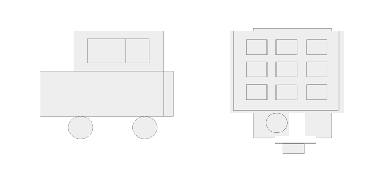

Distance is  0.002083257306367159
It's similar


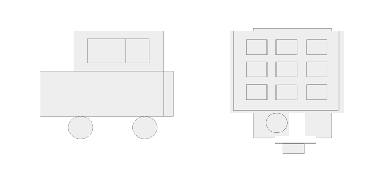

Scoring...............................
Score of similarity is  2


In [22]:
verify_ml_approach("images/image2.png", "images/image1_modified.png")
predict_2_models("images/image2.png", "images/image1_modified.png")

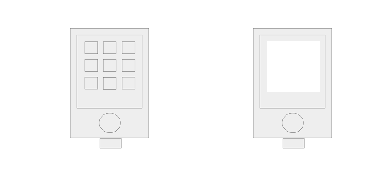

Distance is  0.0012875533429905772
It's similar


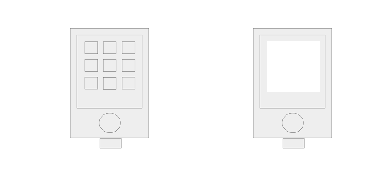

Scoring...............................
Score of similarity is  8


In [19]:
verify_ml_approach("images/image1.png", "images/image1_modified1.png")
predict_2_models("images/image1.png", "images/image1_modified1.png")

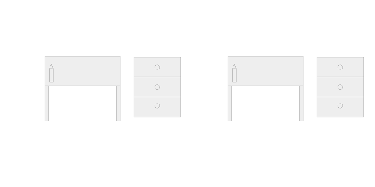

Distance is  0.0
It's similar


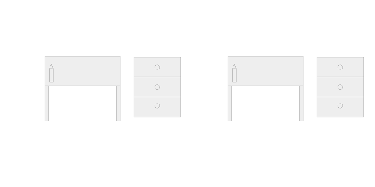

Scoring...............................
Score of similarity is  10


In [20]:
verify_ml_approach("images/image3.png", "images/image3.png")
predict_2_models("images/image3.png", "images/image3.png")

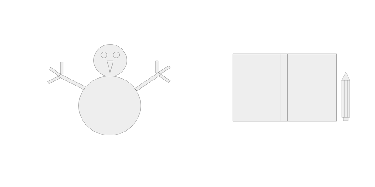

Distance is  0.0020267933141440153
It's similar


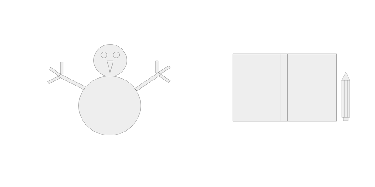

Scoring...............................
Score of similarity is  10


In [21]:
verify_ml_approach("images/image5.png", "images/image6.png")
predict_2_models("images/image5.png", "images/image6.png")